# Préparez des données pour un organisme de santé publique

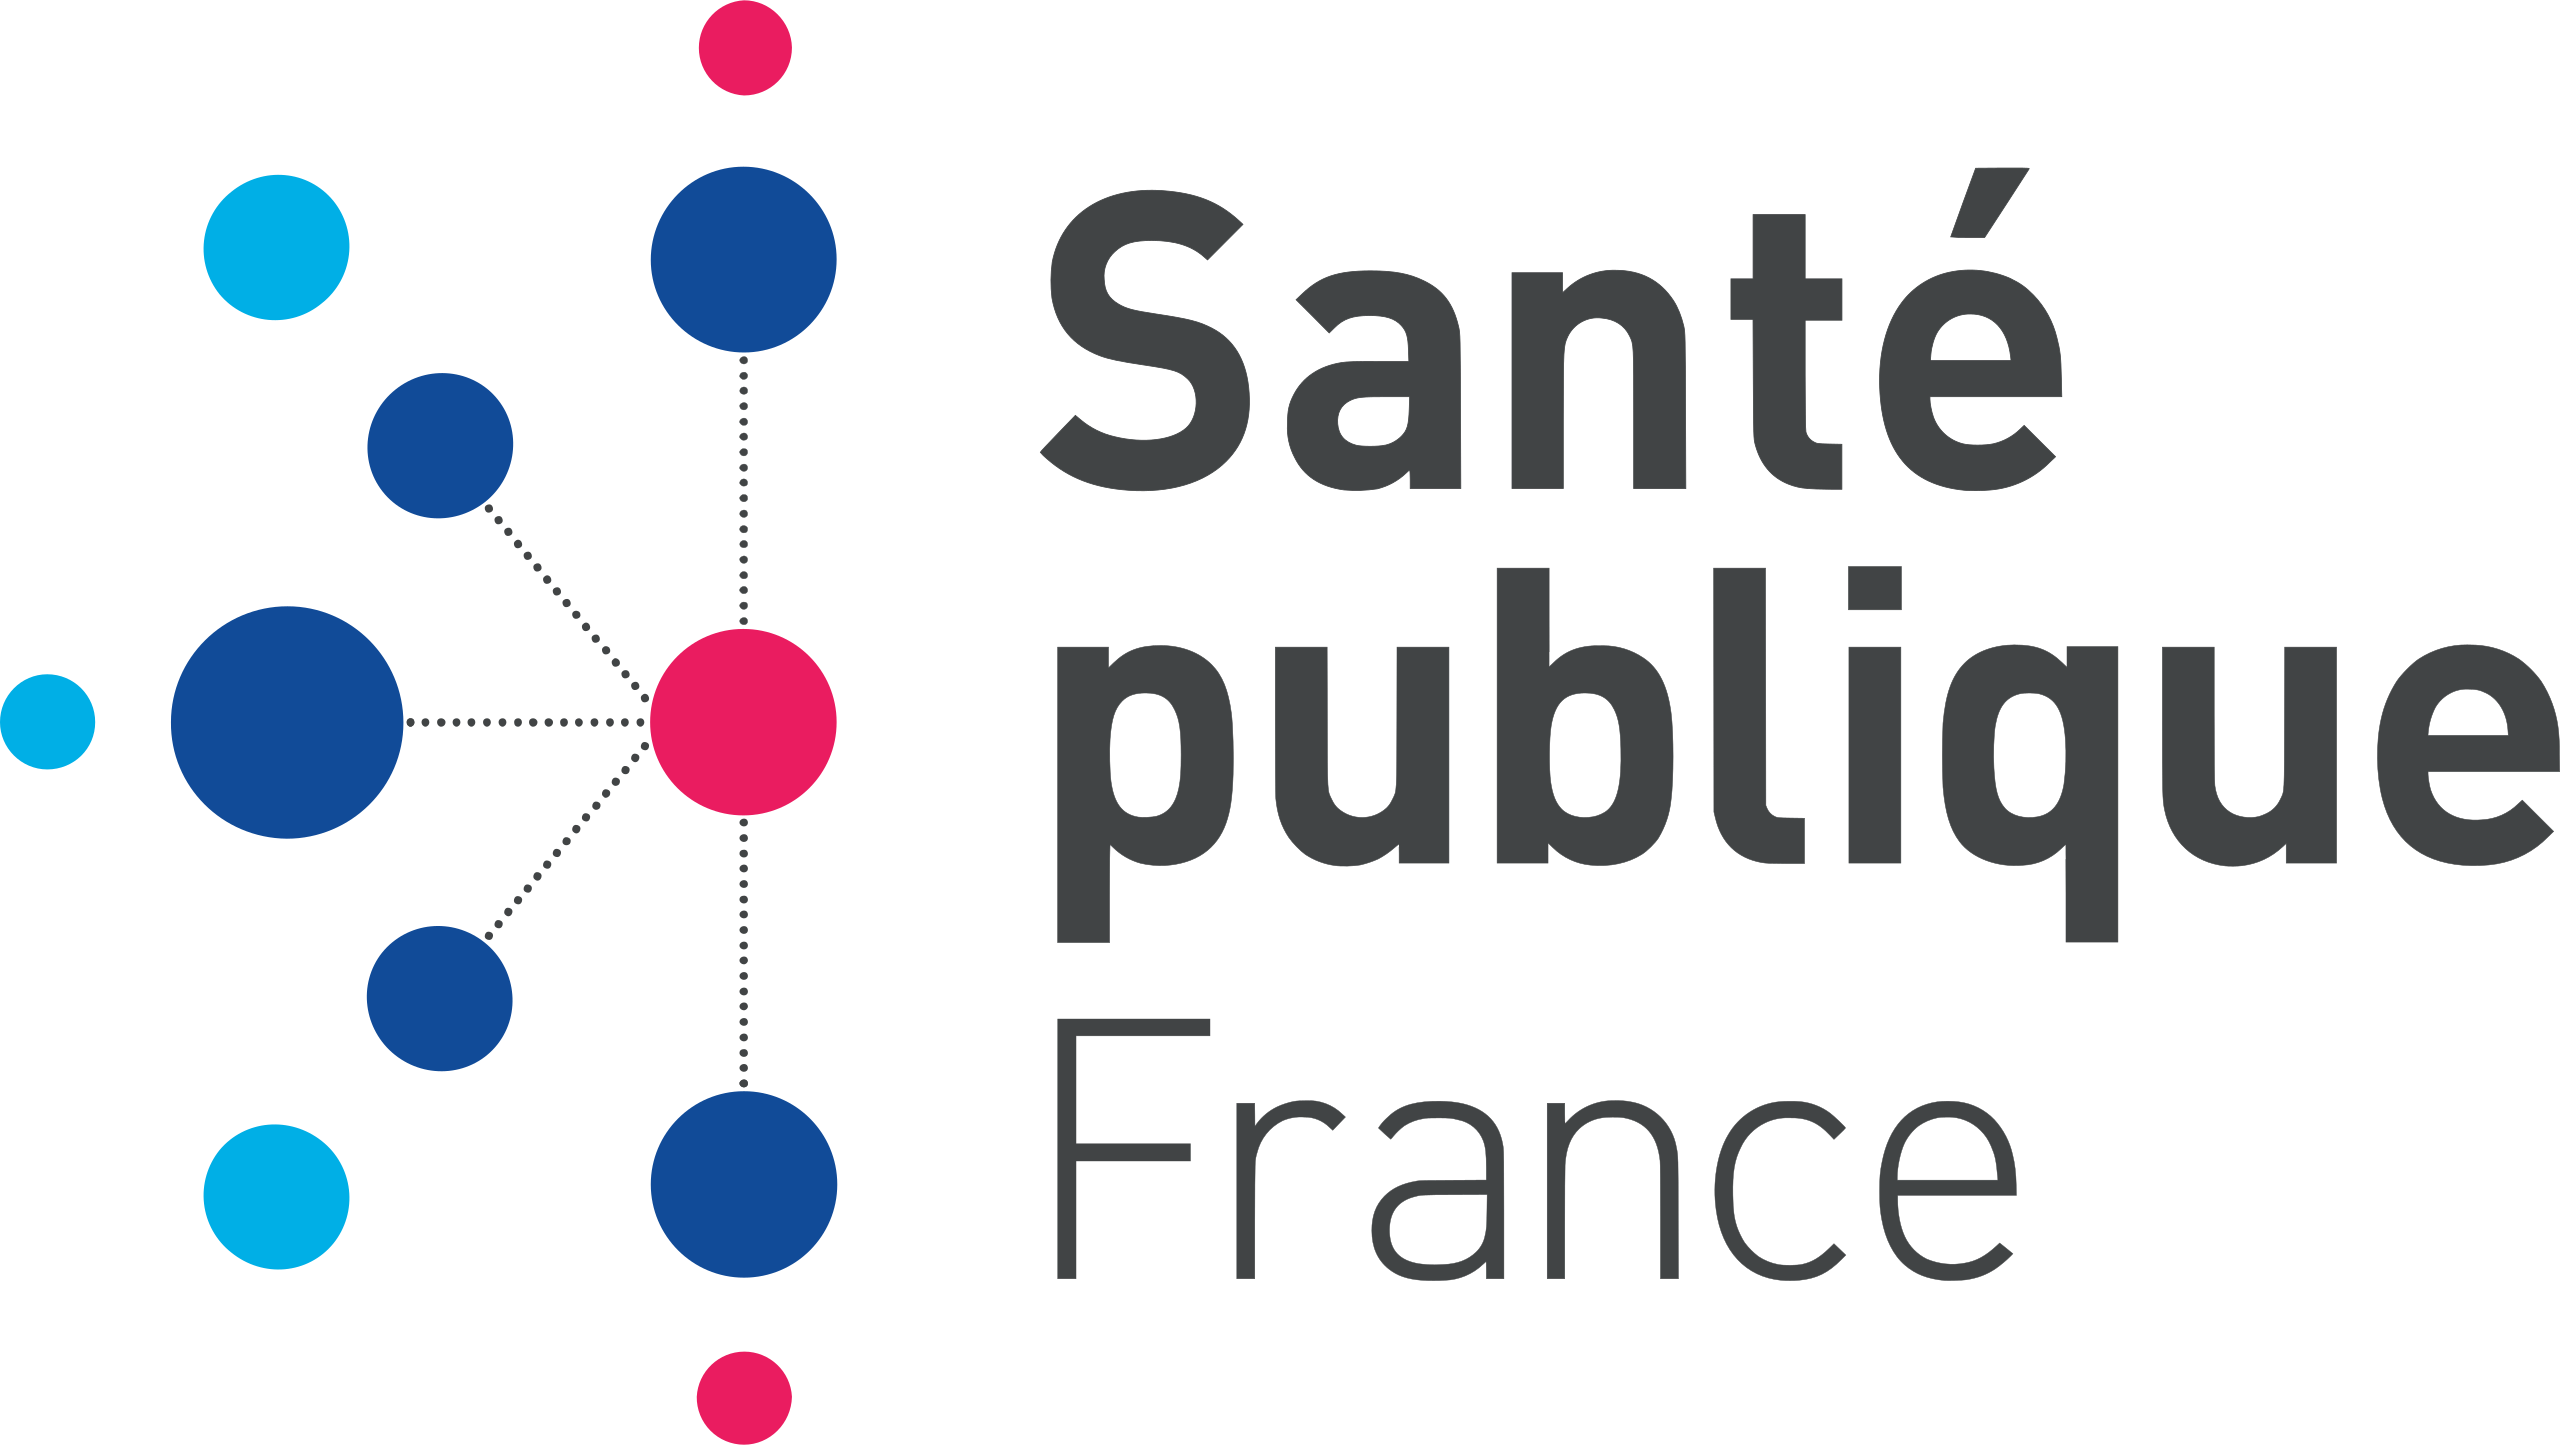



## 1. Introduction

L'agence Santé publique France souhaite améliorer sa base de données Open Food Facts qui permet de connaître la qualité nutritionnelle de leur produits.  
Ils souhaitent développer un système de suggestion ou d'auto-complétion pour remplir la base de données plus efficacement.

Mon rôle est de déterminer la faisabilité de cette application en analysant ces données et en produisants des graphiques compréhensible à tous.

**Données d'entrée**:
- [Tous les produits](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip)
- [Description de toutes les colonnes](https://world.openfoodfacts.org/data/data-fields.txt)

**Données de sortie**: 
- Rapport d'éxploration
- Conclusion sur la faisabilité de l'application.

<!---
Critères d'évaluation:
- Vous avez défini les objectifs de son nettoyage de données en fonction de la problématique métier
- Vous avez défini sa démarche de préparation et nettoyage des données
-->

---

Je remarque que le fichier ne contient aucune données qui entrerait en conflit avec les 5 principes du RGPD (Règlement Général sur la Protection des Données):
- **Le principe de finalité** : le responsable d'un fichier ne peut enregistrer et utiliser des informations sur des personnes physiques que dans un but bien précis, légal et légitime ;
- **Le principe de proportionnalité et de pertinence** : les informations enregistrées doivent être pertinentes et strictement nécessaires au regard de la finalité du fichier ;
- **Le principe d'une durée de conservation limitée** : il n'est pas possible de conserver des informations sur des personnes physiques dans un fichier pour une durée indéfinie. Une durée de conservation précise doit être fixée, en fonction du type d'information enregistrée et de la finalité du fichier ;
- **Le principe de sécurité et de confidentialité** : le responsable du fichier doit garantir la sécurité des informations qu'il détient. Il doit en particulier veiller à ce que seules les personnes autorisées aient accès à ces informations ;
- **Les droits des personnes**.

Afin de lire, nettoyer, analyser et visualiser les données, j'utilise les librairies suivantes:
- Pandas, 
- NumPy,
- Seaborn,
- Scikit-learn,
- Matplotlib.

In [1]:
import os.path 
import pandas as pd
import numpy as np
import math  

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer  
from sklearn.model_selection import GridSearchCV  
  
import seaborn as sns
import matplotlib.pyplot as plt

# Allow pandas to display all columns when displaying a table
pd.set_option("display.max_columns", None)

product_csv_path = '../input/fr.openfoodfacts.org.products.csv'
products = pd.read_csv(product_csv_path, sep='\t', low_memory=False)
products.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,packaging,packaging_tags,brands,brands_tags,categories,categories_tags,categories_fr,origins,origins_tags,manufacturing_places,manufacturing_places_tags,labels,labels_tags,labels_fr,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_fr,ingredients_text,allergens,allergens_fr,traces,traces_tags,traces_fr,serving_size,no_nutriments,additives_n,additives,additives_tags,additives_fr,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,ingredients_that_may_be_from_palm_oil_n,ingredients_that_may_be_from_palm_oil,ingredients_that_may_be_from_palm_oil_tags,nutrition_grade_uk,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,states,states_tags,states_fr,main_category,main_category_fr,image_url,image_small_url,energy_100g,energy-from-fat_100g,fat_100g,saturated-fat_100g,butyric-acid_100g,caproic-acid_100g,caprylic-acid_100g,capric-acid_100g,lauric-acid_100g,myristic-acid_100g,palmitic-acid_100g,stearic-acid_100g,arachidic-acid_100g,behenic-acid_100g,lignoceric-acid_100g,cerotic-acid_100g,montanic-acid_100g,melissic-acid_100g,monounsaturated-fat_100g,polyunsaturated-fat_100g,omega-3-fat_100g,alpha-linolenic-acid_100g,eicosapentaenoic-acid_100g,docosahexaenoic-acid_100g,omega-6-fat_100g,linoleic-acid_100g,arachidonic-acid_100g,gamma-linolenic-acid_100g,dihomo-gamma-linolenic-acid_100g,omega-9-fat_100g,oleic-acid_100g,elaidic-acid_100g,gondoic-acid_100g,mead-acid_100g,erucic-acid_100g,nervonic-acid_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,sucrose_100g,glucose_100g,fructose_100g,lactose_100g,maltose_100g,maltodextrins_100g,starch_100g,polyols_100g,fiber_100g,proteins_100g,casein_100g,serum-proteins_100g,nucleotides_100g,salt_100g,sodium_100g,alcohol_100g,vitamin-a_100g,beta-carotene_100g,vitamin-d_100g,vitamin-e_100g,vitamin-k_100g,vitamin-c_100g,vitamin-b1_100g,vitamin-b2_100g,vitamin-pp_100g,vitamin-b6_100g,vitamin-b9_100g,folates_100g,vitamin-b12_100g,biotin_100g,pantothenic-acid_100g,silica_100g,bicarbonate_100g,potassium_100g,chloride_100g,calcium_100g,phosphorus_100g,iron_100g,magnesium_100g,zinc_100g,copper_100g,manganese_100g,fluoride_100g,selenium_100g,chromium_100g,molybdenum_100g,iodine_100g,caffeine_100g,taurine_100g,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,NaN,NaN,Ferme t'y R'nao,ferme-t-y-r-nao,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:FR,en:france,France,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"en:to-be-completed, en:nutrition-facts-to-be-c...","en:to-be-completed,en:nutrition-facts-to-be-co...","A compléter,Informations nutritionnelles à com...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US,en:united-states,États-Unis,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,NaN,NaN,NaN,NaN,28 g (1 ONZ),NaN,0.0,[ bananas -> en:bananas ]

J'observe les nombre de lignes et colonnes

In [2]:
products.shape

(320772, 162)

## 2. Nettoyage

<!-- Critères d'évaluation

- Vous avez éliminé les variables non pertinentes pour la problématique de l'application.

- Vous avez proposé et justifié au minimum trois méthodes de traitement des valeurs manquantes, adaptées aux variables concernées (médiane, mise à 0, IterativeImputer, KNN, suppression…). 

- Vous avez identifié, quantifié et traité les valeurs aberrantes de chaque variable, en tenant compte du contexte métier. 
- Vous avez traité les duplicats de variables et d'enregistrements. 

- Vous avez mis en œuvre une automatisation de certains traitements, à l'aide de fonctions et méthodes adaptées. 


- DONE - Vous avez veillé au respect des normes RGPD pendant les opérations de nettoyage. Dans ce projet cela signifie :
-- d’expliquer les 5 grands principes RGPD et de montrer que votre travail n’a pas de lien avec les RGPD.

-->

### 2.1 Valeurs manquantes

J'affiche le pourcentage de valeurs manquantes dans un histogramme par step de 10.

/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


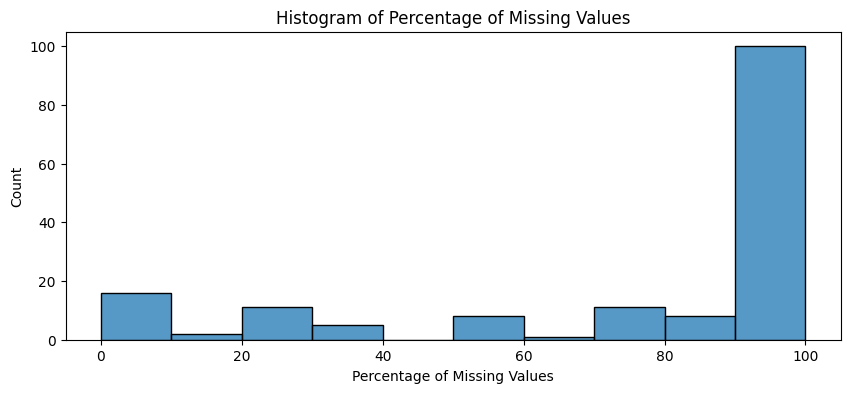

Variables avec moins de 25% de valeur manquantes:
- last_modified_t: 0.00%
- last_modified_datetime: 0.00%
- creator: 0.00%
- created_t: 0.00%
- created_datetime: 0.00%
- code: 0.01%
- url: 0.01%
- states_fr: 0.01%
- states_tags: 0.01%
- states: 0.01%
- countries: 0.09%
- countries_tags: 0.09%
- countries_fr: 0.09%
- product_name: 5.54%
- brands: 8.86%
- brands_tags: 8.86%
- energy_100g: 18.60%
- proteins_100g: 18.97%
- salt_100g: 20.35%
- sodium_100g: 20.36%
- ingredients_text: 22.39%
- ingredients_from_palm_oil_n: 22.39%
- additives_n: 22.39%
- ingredients_that_may_be_from_palm_oil_n: 22.39%
- additives: 22.40%
- sugars_100g: 23.63%
- fat_100g: 23.97%
- carbohydrates_100g: 24.06%


In [3]:
# Assuming you have a pandas DataFrame called 'products'  
missing_percentage = products.isna().mean() * 100  
  
# Create a histogram of the missing percentage
plt.figure(figsize=(10, 4))
sns.histplot(data=missing_percentage, bins=range(0, 101, 10))  
plt.xlabel("Percentage of Missing Values")  
plt.ylabel("Count")  
plt.title("Histogram of Percentage of Missing Values")  
plt.show()

below_25_percent = missing_percentage[missing_percentage < 25].sort_values()
count = len(below_25_percent)  
print("Variables avec moins de 25% de valeur manquantes:")  
for variable, percentage in below_25_percent.items():  
    print(f"- {variable}: {percentage:.2f}%")  

Je décide de faire mon nettoyage par type de catégories.
Comme défini dans le fichier de description

### 2.2 Analyse de chaque type de colonne

In [4]:
general_columns = [
    "code",
    "url",
    "creator",
    "created_t",
    "created_datetime",
    "last_modified_t",
    "last_modified_datetime",
    "product_name",
    "generic_name",
    "quantity",
]

ingredients_columns = [
    "ingredients_text",
    "traces",
    "traces_tags",   
]

tags_columns = [
    "packaging",
    "packaging_tags",
    "brands",
    "brands_tags",
    "categories",
    "categories_tags",
    "categories_fr",
    "origins",
    "origins_tags",
    "manufacturing_places",
    "manufacturing_places_tags",
    "labels",
    "labels_tags",
    "labels_fr",
    "emb_codes",
    "emb_codes_tags",
    "first_packaging_code_geo",
    "cities",
    "cities_tags",
    "purchase_places",
    "stores",
    "countries",
    "countries_tags",
    "countries_fr",
    "states_fr", # Not in data-fields.txt
    "states", # Not in data-fields.txttxt
    "states_tags", # Not in data-fields.txt
]

misc_columns = [
    "serving_size",
    "no_nutriments",
    "additives_n",
    "additives",
    "additives_tags",
    "ingredients_from_palm_oil_n",
    "ingredients_from_palm_oil",
    "ingredients_from_palm_oil_tags",
    "ingredients_that_may_be_from_palm_oil_n",
    "ingredients_that_may_be_from_palm_oil",
    "ingredients_that_may_be_from_palm_oil_tags",
    "nutrition_grade_fr",
    "main_category",
    "main_category_fr",
    "image_url",
    "image_small_url",
]

nutritions_columns = [
    "energy_100g", # Seems to be in kJ
    # "energy-kj_100g", Not in this dataset
    # "energy-kcal_100g", Not in this dataset
    "proteins_100g",
    "casein_100g",
    "serum-proteins_100g",
    "nucleotides_100g",
    "carbohydrates_100g",
    "sugars_100g",
    "sucrose_100g",
    "glucose_100g",
    "fructose_100g",
    "lactose_100g",
    "maltose_100g",
    "maltodextrins_100g",
    "starch_100g",
    "polyols_100g",
    "fat_100g",
    "saturated-fat_100g",
    "butyric-acid_100g",
    "caproic-acid_100g",
    "caprylic-acid_100g",
    "capric-acid_100g",
    "lauric-acid_100g",
    "myristic-acid_100g",
    "palmitic-acid_100g",
    "stearic-acid_100g",
    "arachidic-acid_100g",
    "behenic-acid_100g",
    "lignoceric-acid_100g",
    "cerotic-acid_100g",
    "montanic-acid_100g",
    "melissic-acid_100g",
    "monounsaturated-fat_100g",
    "polyunsaturated-fat_100g",
    "omega-3-fat_100g",
    "alpha-linolenic-acid_100g",
    "eicosapentaenoic-acid_100g",
    "docosahexaenoic-acid_100g",
    "omega-6-fat_100g",
    "linoleic-acid_100g",
    "arachidonic-acid_100g",
    "gamma-linolenic-acid_100g",
    "dihomo-gamma-linolenic-acid_100g",
    "omega-9-fat_100g",
    "oleic-acid_100g",
    "elaidic-acid_100g",
    "gondoic-acid_100g",
    "mead-acid_100g",
    "erucic-acid_100g",
    "nervonic-acid_100g",
    "trans-fat_100g",
    "cholesterol_100g",
    "fiber_100g",
    "sodium_100g",
    "alcohol_100g",
    "vitamin-a_100g",
    "vitamin-d_100g",
    "vitamin-e_100g",
    "vitamin-k_100g",
    "vitamin-c_100g",
    "vitamin-b1_100g",
    "vitamin-b2_100g",
    "vitamin-pp_100g",
    "vitamin-b6_100g",
    "vitamin-b9_100g",
    "vitamin-b12_100g",
    "biotin_100g",
    "pantothenic-acid_100g",
    "silica_100g",
    "bicarbonate_100g",
    "potassium_100g",
    "chloride_100g",
    "calcium_100g",
    "phosphorus_100g",
    "iron_100g",
    "magnesium_100g",
    "zinc_100g",
    "copper_100g",
    "manganese_100g",
    "fluoride_100g",
    "selenium_100g",
    "chromium_100g",
    "molybdenum_100g",
    "iodine_100g",
    "caffeine_100g",
    "taurine_100g",
    "ph_100g",
    "fruits-vegetables-nuts_100g",
    "carbon-footprint_100g",
    "nutrition-score-fr_100g",
    "nutrition-score-uk_100g",
    "glycemic-index_100g", # In the dataset but not in data-fields.txt
    "water-hardness_100g", # In the dataset but not in data-fields.txt
]

nutritions_cleaned = products[nutritions_columns].fillna(0)

In [5]:
def create_color_palette(values, thresholds, colors):  
    """Create a color palette based on the given thresholds and colors."""  
    color_palette = []  
    for value in values:  
        for i in range(len(thresholds)):  
            if value < thresholds[i]:  
                color_palette.append(colors[i])  
                break  
        else:  
            color_palette.append(colors[-1])  
    return color_palette

def display_graph_missing_data(df, figsize_height):
    # Calculate the missing value percentage and count for each column  
    missing_data = df.isna().mean() * 100  
    missing_count = df.isna().sum()  
    unique_count = df.nunique()
    # Create a DataFrame to store the missing value percentage and count  
    missing_df = pd.DataFrame({"Missing Percentage": missing_data, "Missing Count": missing_count, "Unique Count": unique_count})  

    # Sort the DataFrame by missing percentage in descending order  
    missing_df = missing_df.sort_values(by="Missing Percentage", ascending=False)  
    thresholds = [25, 50, 75, 100]  
    colors = ["#4fff87", "#4fc4ff", "#ffbc4f", "#ff4f4f"]  

    # Map the colors based on the percentage value  

    color_palette = create_color_palette(missing_df["Missing Percentage"], thresholds, colors)  

    plt.figure(figsize=(10, figsize_height)) # Adjust the figure size as per your preference  
    ax = sns.barplot(x="Missing Percentage", y=missing_df.index, data=missing_df, palette=color_palette) # Create a horizontal bar plot  

    # Add labels and legend to the plot  
    plt.xlabel("Missing Value Percentage")  
    plt.ylabel("Column")  
    plt.title("Percentage of Missing Values for Selected Columns")  

    # Add the count of missing values inside each bar  
    # for i, (value, name) in enumerate(zip(missing_df["Missing Count"], missing_df.index)):  
    #     ax.text(1, i, f" {value} ", va="center")  
    for i, (missing_value, unique_value, name) in enumerate(  
        zip(missing_df["Missing Count"], missing_df["Unique Count"], missing_df.index)  
    ):
        ax.text(1, i, f"Missing: {missing_value}", va="center")
        ax.text(20, i, f"Unique: {unique_value}", va="center")
    # Create a custom legend  
    legend_labels = [f"{thresholds[i]-25}-{thresholds[i+1]-25}%" if i != len(thresholds)-1 else f"{thresholds[i]-25}+%" for i in range(len(thresholds))]  
    colors_scaled = [plt.cm.colors.to_rgb(color) for color in colors]  
    legend_elements = [plt.Line2D([0], [0], marker="s", color="white", markerfacecolor=colors_scaled[i], markersize=10) for i in range(len(colors))]  
    plt.legend(legend_elements, legend_labels, loc="lower right")
    
    # Display the plot  
    plt.show()

#### 2.2.1 General

/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


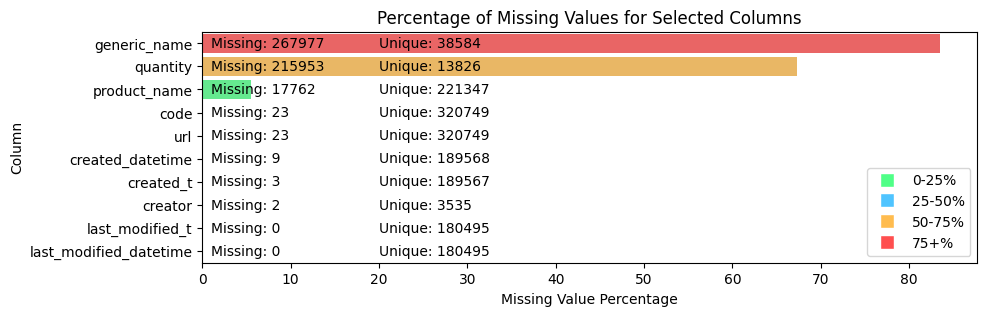

In [6]:
display_graph_missing_data(products[general_columns], 3)

/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


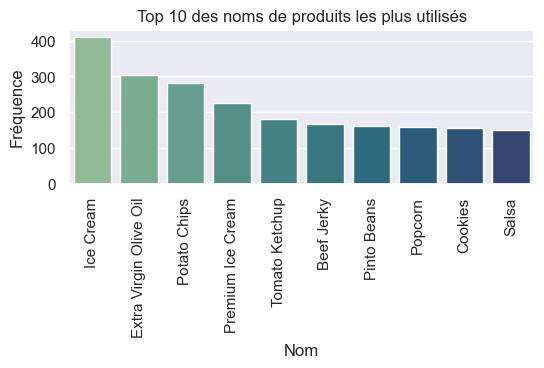

In [7]:
# Assuming 'products' is the name of your DataFrame  
top_10_products = products['product_name'].value_counts().head(10)  
  
# Create a bar plot using Seaborn  
sns.set(style="darkgrid")  
plt.figure(figsize=(6, 2))  
sns.barplot(x=top_10_products.index, y=top_10_products.values, palette="crest")  
plt.xticks(rotation=90)  
plt.xlabel('Nom')  
plt.ylabel('Fréquence')  
plt.title('Top 10 des noms de produits les plus utilisés')  
plt.show()  

#### 2.2.2 Ingrédients

/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


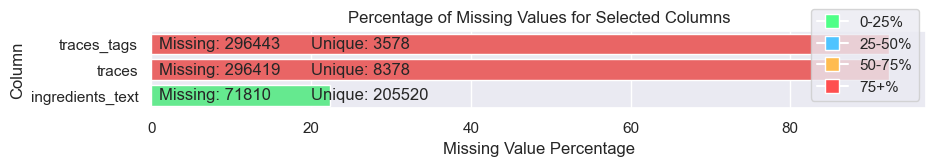

In [8]:
display_graph_missing_data(products[ingredients_columns], 1)

In [9]:
#### 2.2.3 Tags

/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


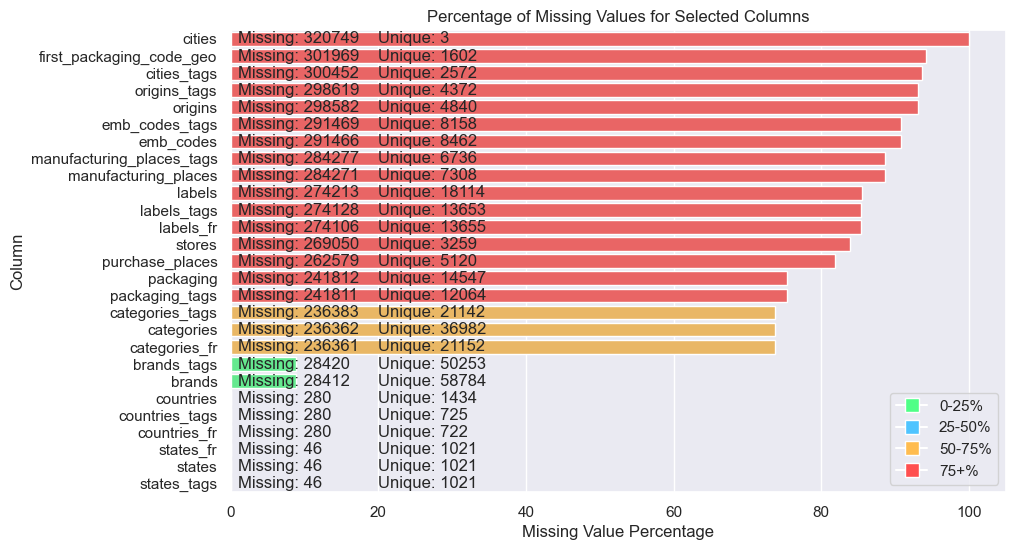

In [10]:
display_graph_missing_data(products[tags_columns], 6)

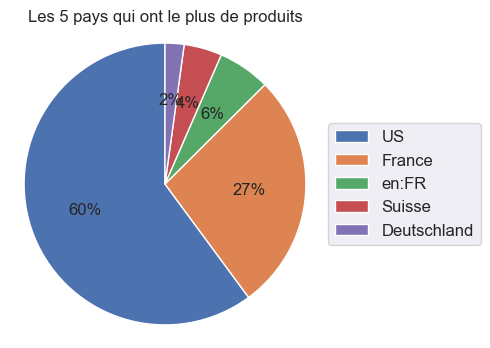

In [11]:
# Assuming 'products' is the name of your DataFrame  
top_5_countries = products['countries'].value_counts().head(5)  
  
# Create a pie chart  
plt.figure(figsize=(4, 4))  
patches, texts, _ = plt.pie(top_5_countries.values, startangle=90, autopct='%1.f%%')  

plt.title('Les 5 pays qui ont le plus de produits')  
plt.axis('equal')
plt.legend(patches, top_5_countries.index, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)  

plt.show()

On remarque que les US et la France sont les pays contenant +75% de tous les produits.
On pourrait penser à établir une suggestion pour les produits représentants des similarités sur les autres pays.

Exemple:  
- Si l'on rentre un nouveau produit appelé "Ice-cream", on pourra observer les produits similaires par pays
- On imagine un tableau qui affiche le nombre de produits nommé Ice-Cream par pays. 
    - _On pourrait également se baser sur les tags du pays ou d'autres critères._
- L'application suggère automatiquement le pays s'il a une majorité
    - soit de +50% de produits
    - soit classé numéro 1 avec +10% de produits comparé au pays placé second

In [12]:
# Assuming 'products' is the name of your DataFrame  
top_5_states = products['states_fr'].value_counts().head(5)  
top_5_states_table = top_5_states.to_frame().reset_index()  
top_5_states_table.columns = ['State', 'Count']  
  
print(top_5_states_table)  

                                               State   Count
0  A compléter,Informations nutritionnelles compl...  168905
1  A vérifier,Complet,Informations nutritionnelle...   23401
2  A vérifier,Complet,Informations nutritionnelle...   19080
3  A compléter,Informations nutritionnelles à com...    8453
4  A compléter,Informations nutritionnelles compl...    8099


#### 2.2.1 Divers

/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


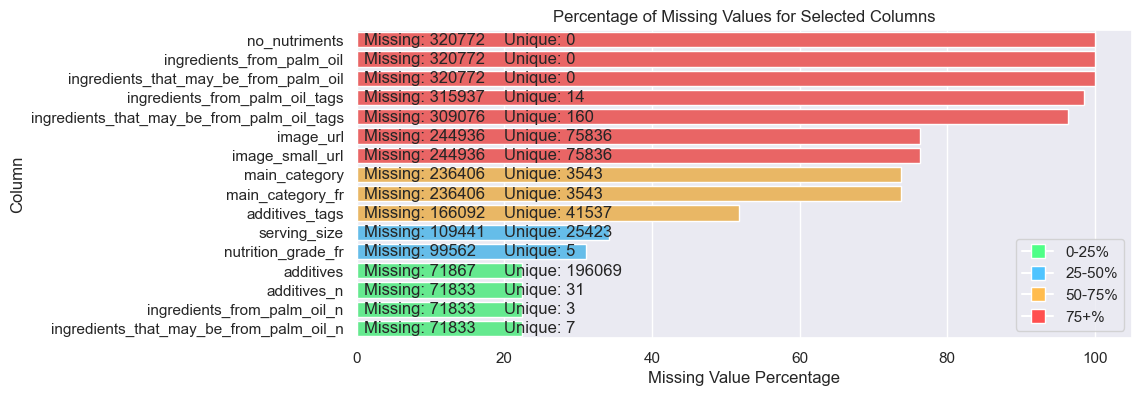

In [13]:
display_graph_missing_data(products[misc_columns], 4)

/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


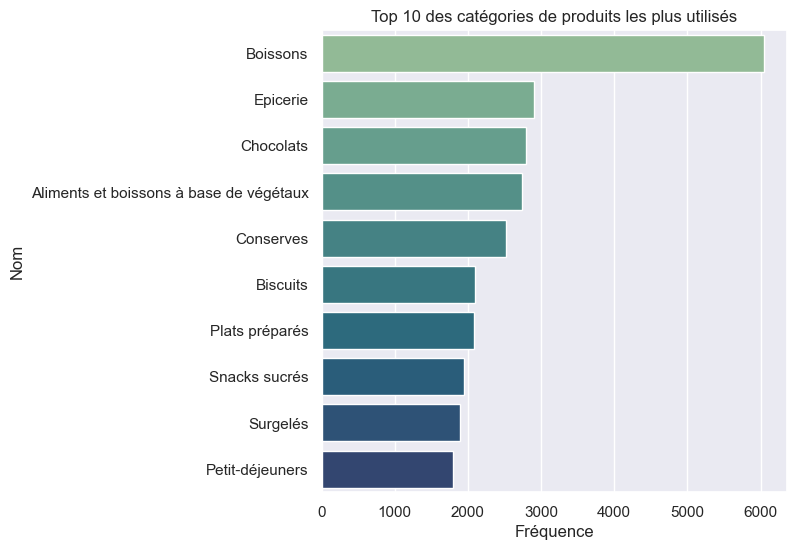

In [14]:
top_10_cat = products['main_category_fr'].value_counts().head(10)  
sns.set(style="darkgrid")  
plt.figure(figsize=(6, 6))  
sns.barplot(x=top_10_cat.values, y=top_10_cat.index, palette="crest")  
plt.xlabel('Fréquence')  
plt.ylabel('Nom')  
plt.title('Top 10 des catégories de produits les plus utilisés')  
plt.show()

#### 2.2.1 Nutritions

/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/m/.pyenv/versions/3.10.12/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


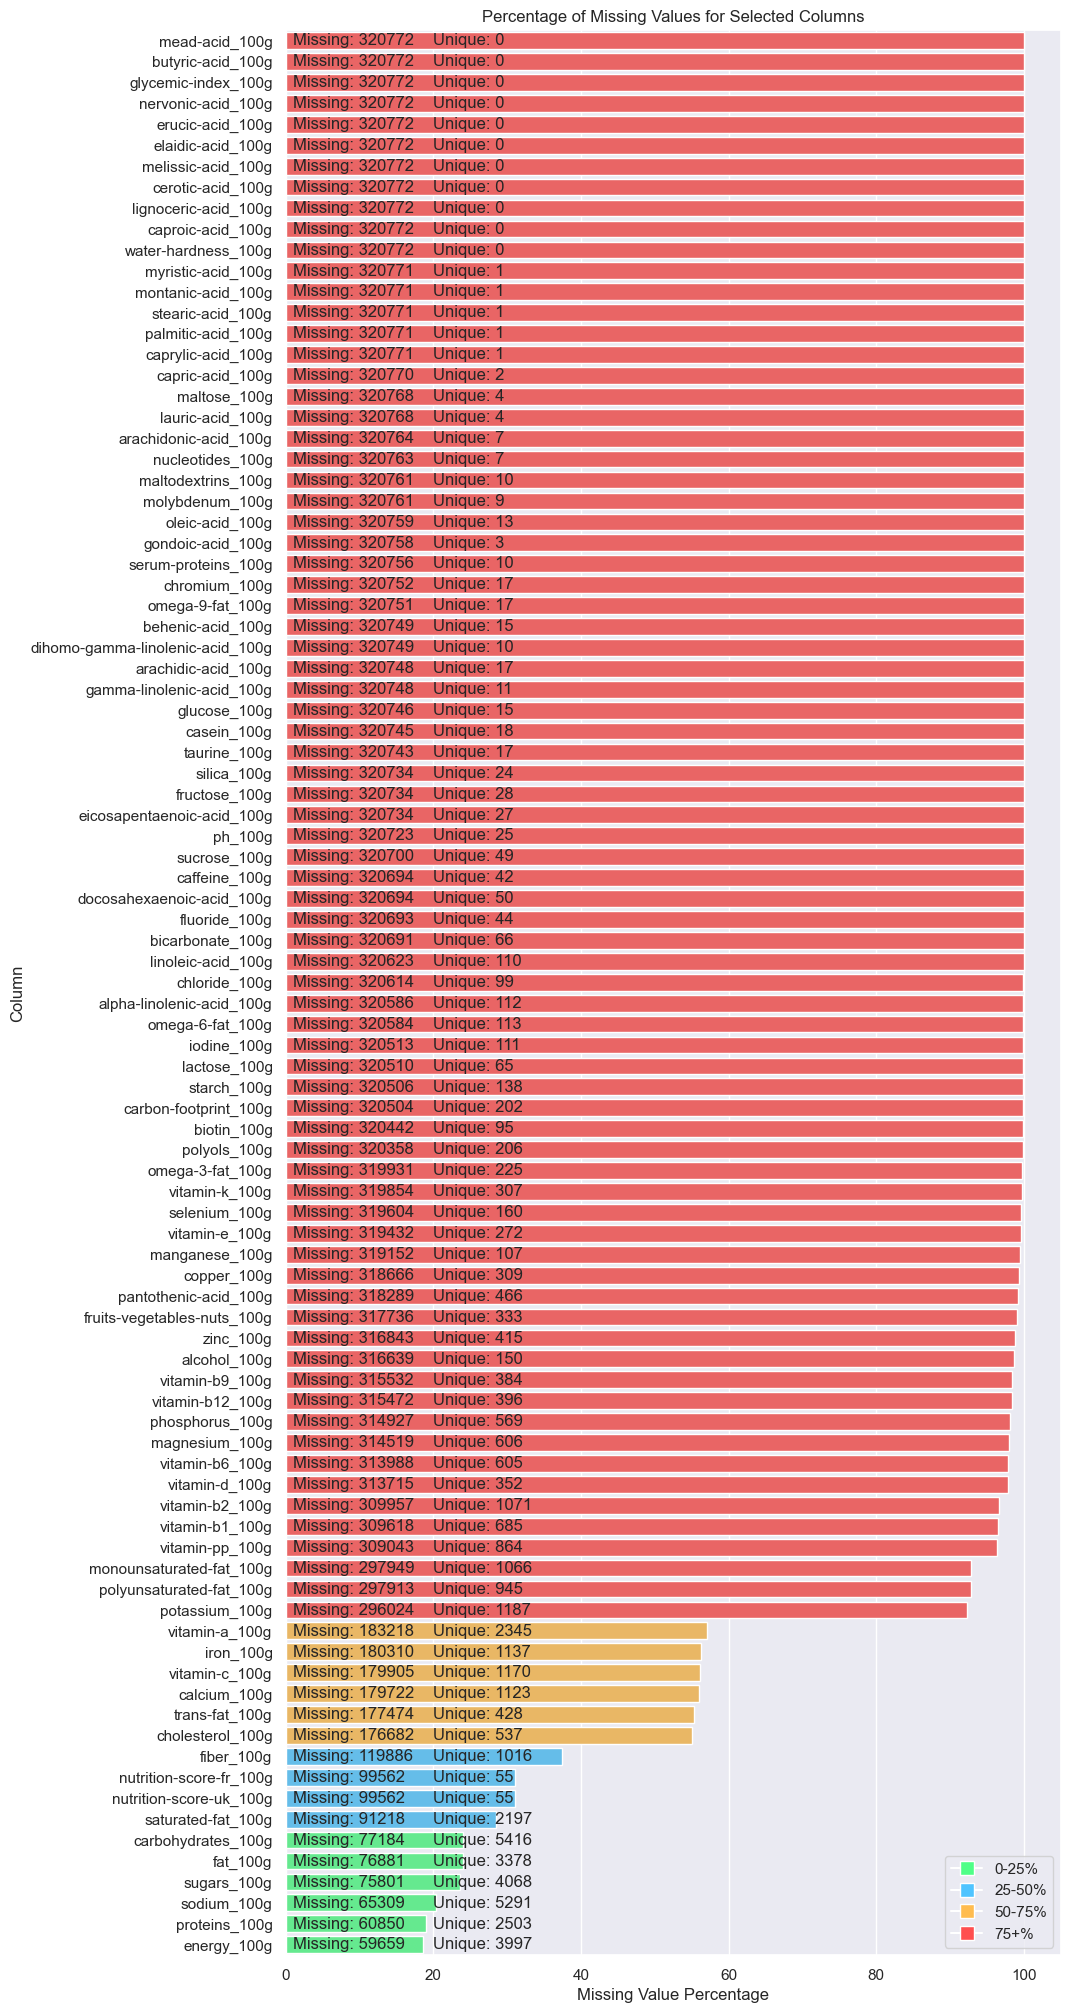

In [15]:
display_graph_missing_data(products[nutritions_columns], 25)